In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import Counter
from sklearn.metrics import f1_score, recall_score, roc_auc_score, auc, precision_recall_curve


In [26]:
df = pd.read_csv("Datos_regresion.csv") # read in data downloaded to the local directory
df.head()

,Edad,Diag.Ing1,Diag.Ing2,Diag.Egr1,Diag.Egr2,APACHE,TiempoVAM,Fallece
0,35,1,0,1,0,10,2,0
1,87,2,0,2,0,16,2,0
2,70,4,0,4,0,11,2,0
3,24,13,0,13,5,11,2,0
4,24,3,0,3,0,17,3,0


In [27]:
# Se crea un nuevo dataset con los datos de forma tal que puedan ser procesados por el algoritmo
df_new = df[["Edad", "APACHE", "TiempoVAM"]]
lista = ["Diag.Ing1", "Diag.Ing2", "Diag.Egr1", "Diag.Egr2"]
for i in lista:
    new = pd.get_dummies(df[i], prefix=i)
    df_new = pd.concat([df_new , new], axis = 1)
df_new = pd.concat([df_new , df.Fallece], axis =1)
df = df_new
df.head()

,Edad,APACHE,TiempoVAM,Diag.Ing1_1,Diag.Ing1_2,Diag.Ing1_3,Diag.Ing1_4,Diag.Ing1_5,Diag.Ing1_6,Diag.Ing1_7,...,Diag.Egr2_21,Diag.Egr2_22,Diag.Egr2_23,Diag.Egr2_24,Diag.Egr2_25,Diag.Egr2_27,Diag.Egr2_33,Diag.Egr2_34,Diag.Egr2_36,Fallece
0,35,10,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,87,16,2,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,70,11,2,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,24,11,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,24,17,3,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [28]:
# Tomamos un dato para predecir su probabilidad de morir
x_pred_f = df.loc[df.Fallece == 1]
x_pred_f = x_pred_f[1:2]
x_pred_f = x_pred_f.drop("Fallece", axis =1)

In [29]:
# Tomamos un dato para predecir su probabilidad de vivir
x_pred_v = df.loc[df.Fallece == 0]
x_pred_v = x_pred_v[:1]
x_pred_v = x_pred_v.drop("Fallece", axis =1)

In [30]:
print(df.shape)
print(pd.value_counts(df['Fallece'], sort = True))

(208, 117)
Fallece
0    176
1     32
Name: count, dtype: int64


C:\Users\anportal\AppData\Local\Temp\ipykernel_21260\1983737910.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df['Fallece'], sort = True))


C:\Users\anportal\AppData\Local\Temp\ipykernel_21260\545876988.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Fallece'], sort = True)


Text(0, 0.5, 'Number of Observations')

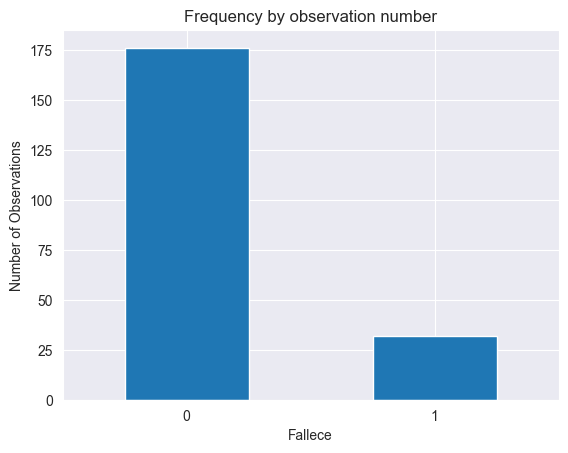

In [31]:
count_classes = pd.value_counts(df['Fallece'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Frequency by observation number")
plt.xlabel("Fallece")
plt.ylabel("Number of Observations")

In [32]:
#definimos nuestras etiquetas y features
y = df['Fallece']
X = df.drop('Fallece', axis=1)

In [33]:
# Se realiza el OVerSampling
os =  RandomOverSampler(random_state=42)
X_train_res, y_train_res = os.fit_resample(X, y)
print ("Distribution before resampling {}".format(Counter(y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 176, 1: 32})
Distribution labels after resampling Counter({0: 176, 1: 176})


In [34]:
# Dividir los datos en conjunto de entrenamiento + validación y conjunto de prueba
X_train, X_test_val, y_train, y_test_val = train_test_split(X_train_res, y_train_res, train_size=0.8, random_state=42)

# Dividir el conjunto de entrenamiento + validación en conjunto de entrenamiento y conjunto de validación
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [35]:
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de validación:", len(X_val))
print("Tamaño del conjunto de prueba:", len(X_test))

Tamaño del conjunto de entrenamiento: 210
Tamaño del conjunto de validación: 71
Tamaño del conjunto de prueba: 71


In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': [ 'l1', 'l2', None]
}

# Configurar la búsqueda en cuadrícula
clf = GridSearchCV(LogisticRegression(), param_grid, cv=5)
clf.fit(X_val, y_val)

# Realizar predicciones en el conjunto de prueba
#y_pred = clf.predict(X_test)

# Obtener los mejores parámetros
best_params = clf.best_params_
# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:")
print(best_params)

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_m

Mejores parámetros encontrados:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more deta

In [37]:
# Crear un nuevo modelo con los mejores hiperparámetros encontrados
best_lr_model = LogisticRegression(**best_params)

# Entrenar el modelo con el conjunto de datos completo de entrenamiento + validación
best_lr_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_lr_model.predict(X_test)

In [38]:
# Resultado del algorimo: [probabilidad de que viva: probabilidad de que muera]
prob = clf.predict_proba(X)
np.savetxt("prob.csv", prob, delimiter=',')

In [39]:
# Resultado del algorimo: [probabilidad de que viva: probabilidad de que muera]
prob = clf.predict_proba(x_pred_v)
prob

array([[0.9812032, 0.0187968]])

In [40]:
# Metricas
val_mae = mean_absolute_error(y_test , y_pred)
print("Validation MAE: {}".format(val_mae))

val_mse = mean_squared_error(y_test , y_pred)
print("Validation MSE: {}".format(val_mse))

val_rmse = mean_squared_error(y_test , y_pred, squared=False)
print("Validation RMSE: {}".format(val_rmse))

Validation MAE: 0.14084507042253522
Validation MSE: 0.14084507042253522
Validation RMSE: 0.37529331252040077


In [41]:

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

recall = recall_score(y_test, y_pred)
print("Recall Score:", recall)
# Obtener las probabilidades predichas en el conjunto de prueba
y_scores = clf.predict_proba(X_test)[:, 1]

 # Calcular AUC-ROC
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC:", auc_roc)

precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
print("AUC-PR:", auc_pr)



F1 Score: 0.8571428571428572
Recall Score: 0.967741935483871
AUC-ROC: 0.7806451612903226
AUC-PR: 0.6126656932709909


In [42]:
# Cross Validation
print(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore th

0.8416666666666668


C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a t

# MLP

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score


# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (20, 20)],
    'activation': ['logistic', 'relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [100, 200, 300],
}

# Crear el objeto GridSearchCV con balanced_accuracy como métrica
mlp = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)

# Ajustar el modelo al conjunto de entrenamiento
mlp.fit(X_val, y_val)

# Obtener los mejores hiperparámetros
best_params = mlp.best_params_
print("Mejores hiperparámetros:", best_params)

# Predecir en el conjunto de prueba con el modelo ajustado
#y_pred = mlp.predict(X_test)

# Calcular la precisión balanceada en el conjunto de prueba
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Precisión balanceada en el conjunto de prueba:", balanced_accuracy)

Mejores hiperparámetros: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'max_iter': 200, 'solver': 'adam'}
Precisión balanceada en el conjunto de prueba: 0.8713709677419355


C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
best_mlp_model = MLPClassifier(**best_params)

best_mlp_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba con el modelo ajustado
y_pred = best_mlp_model.predict(X_test)

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:

# Metricas
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}")

MAE: 0.2112676056338028
MSE: 0.2112676056338028
MSE: 0.4596385597769217


In [46]:
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

recall = recall_score(y_test, y_pred)
print("Recall Score:", recall)
# Obtener las probabilidades predichas en el conjunto de prueba
y_scores = mlp.predict_proba(X_test)[:, 1]

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC:", auc_roc)

precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
print("AUC-PR:", auc_pr)

F1 Score: 0.7692307692307693
Recall Score: 0.8064516129032258
AUC-ROC: 0.807258064516129
AUC-PR: 0.6532123337345211


In [47]:
cv_scores = cross_val_score(mlp, X, y, cv=10, scoring='neg_mean_squared_error')
print(cv_scores)

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

KeyboardInterrupt: 